# GANs with Python

## Importing Libraries

Like in the previous workshop, we're going to import some libraries for the code.

In [ ]:
!sudo apt-get --allow-change-held-packages --purge remove "*cublas*" "cuda*" "nsight*"

In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda_11.8.0_520.61.05_linux.run
!chmod +x cuda_11.8.0_520.61.05_linux.run
!./cuda_11.8.0_520.61.05_linux.run --silent --toolkit

In [ ]:
import os
os.environ['PATH'] = "/usr/local/cuda-11.8/bin:" + os.environ['PATH']
os.environ['CUDA_HOME'] = "/usr/local/cuda-11.8"
os.environ['LD_LIBRARY_PATH'] = "/usr/local/cuda-11.8/lib64:" +
os.environ.get('LD_LIBRARY_PATH', '')

In [3]:
%pip install tensorflow==2.15.0 tensorflow-probability==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled k

In [ ]:
import os
import tensorflow as tf
import numpy as np

import cv2
import matplotlib.pyplot as plt
from IPython import display

import math
from PIL import Image

print(tf.__version__)

%matplotlib inline

## A quick intro to booleans

### Data type recap

Earlier we discussed different types of variables you see in your code. The main examples we went through were strings (text data), integers (whole-numbers), and floats (numbers with a decimal place).

A quick recap:
```python
my_string = "some text!"
my_float = 39.59382
my_int = 20
```
### Bools and why we're using them

There is another basic data type that we frequently use in Python called booleans (or bools). These can either have the values `True` or `False`. They are used when we want a part of our code to run only when a certain condition has been met.

The code we are using can take several hours to complete (depending on how many images you give and some other factors), so it's been written in such a way that it is possible to save the progress that the code has made so that it can pick up from where it left off later. THis is also useful if the code crashes for whatever reason, as the progress it has made will be preserved.

However, this has the downside of creating progress files in your Google Drive folder that can build up in size quite quickly!

### Bools for our GAN

Before running the code, we will set values for the following bools:
- `do_preprocess` - Determines if we run or skip the code for resizing our image files. This will need to be done at least once.
- `from_checkpoint` - Determines if the GAN starts from scratch, or picks up where it left off by loading a model file. For the first run this will have to be set to False.

In [ ]:
do_preprocess = True
from_checkpoint = False

Here is a basic example of what bools allow you to do:

In [ ]:
my_bool = True

if my_bool:
    print("We will see this printed.")

if my_bool:
    print("This will also be printed")
else:
    print("But not this.")

This code contains an `if` statement. This is another keyword in Python used for conditional execution, basically meaning it helps us write code that is only run some of the time. Here we have used it to ensure that some text is printed only when `my_bool` is True.

Now let's see what happens when something is false.

**Exercise**: What will the output be?

In [ ]:
my_bool = False

if my_bool:
    print("This will be printed. Or will it...?")

You may remember that the first workshop showed us how to use `type()` to find the type of some data. Now we can use it with a bool to see that it is in fact a bool.

In [ ]:
print(type(True), type(False))

### Downloading Some Data

Now that we understand a bit about what booleans do, please set the bool below to True or False depending on whether you've uploaded 500+ image files to Google Drive and have put them in the right folder.

In [ ]:
student_uploaded_own_data = False

## Check the GPU

The Tensorflow library allows us to perform calculations with a GPU or CPU. Setting a GPU up on a desktop machine can be tricky, and sometimes a library won't recognise your GPU as being on your system, even when one is present. For this reason Tensorflow and other Python libraries that utilise the GPU often have a command for checking that a GPU has been detected on the system. This lets you know if you can continue coding, or if you need to do some troubleshooting and figure out why things didn't install properly.

Fortunately we don't need to worry about these things when using Colab. The GPU is already setup for us.

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Google Colab is somtimes able to tell that a Python Notebook requies the GPU, so you should have automatically been given a T4 runtime. You can check this in the top right.

## Prepare the Folder Names (and Data?)

This code will create quite a bit of output, and so we'll need to create some folders to save all these files:

- One folder for the resized images that we will feed into the GAN
- Another folder for the model files that act as snapshots of how far the GAN has come along
- And another for the computer-generated images

Like in the previous workshop, the `os` library will be used for creating our paths. This for safety, as `os` knows what to do regardless of if you are running Windows, Linux, or Mac.

In [ ]:
project_dir = "./drive/MyDrive/"
GANS_WORKSHOP_FOLDER = "gans-workshop-files"

try:
    from google.colab import drive

    drive.mount("/content/drive")

except ModuleNotFoundError:
    project_dir = os.getcwd()

### A bit about `try-except`

The purpose of `try-except` is to give the code a kind of Plan B on what to do when a certain block of code creates an error. Sometimes we are _expecting_ an error in a particular situation, and know what we want the code to do should this happen. This is where a `try-except` block comes into play. It allows us to say "If you run across this problem as the code runs, do this instead."

Here I am mounting the Google Drive folder in a `try-except` block because sometimes I run this code on a desktop. In this scenario the `from google.colab import drive` would lead to a `ModuleNotFoundError`. This is an error you get when you try to import a library that hasn't been installed on your system. When I am running this code on a desktop machine I am not importing Colab and instead getting the input files from my hard drive, and so I tell the code to use `os.getcwd()` as the path to work from. This is the _current working directory_.

Here's an example below of _catching_ an error caused by using the wrong index for a list.

In [ ]:
# This list contains three items
my_list = [1, 2, 3]

# This is how we print the items in a list line by line
print(my_list[0])
print(my_list[1])
print(my_list[2])

try:
    # I am going to try and print the 4th item in the list
    print(my_list[3])
    print("Will the code reach this point?")
except IndexError:
    print("You have accessed something outside of the list.")

## Downloading the Files

Now with that out of the way we can start sorting out the images to give to the GAN. Pick a type of image you want to download if you didn't already prepare some data.

In [ ]:
# @title Choose the type of data you wish to download if you don't already have something { display-mode: "form" }

data_folder_name = "cats"  # @param ["cats", "flowers", "abstract-paintings"]

Now a conditional statement will download some data if it's needed, otherwise we'll go with the data you already have.

In [ ]:
GANS_WORKSHOP_FOLDER = "gans-workshop-files"

if student_uploaded_own_data:
    # Change this to the name of your data folder
    data_folder_name = "pokemon"
else:
    from urllib import request  # This is for downloading
    import zipfile  # This is for handling zip files

    data_path = os.path.join(project_dir, GANS_WORKSHOP_FOLDER, data_folder_name)
    if not os.path.exists(data_path):
        os.makedirs(data_path, exist_ok=True)
        print(f"Downloading {data_folder_name} dataset...")
        local_filename, _ = request.urlretrieve(
            f"https://github.com/DolicaAkelloEgwel/gans-datasets/raw/master/{data_folder_name}.zip"
        )
        with zipfile.ZipFile(local_filename, "r") as downloaded_dataset:
            downloaded_dataset.extractall(data_path)

We're going to need quite a few folders for all the files that will be created from the code. These will be
- A folder for our resized data
- A folder for our model/checkpoint files
- A folder for the GANs output images

For the time being, we're just going to set the paths for these folders. That's because these folders may already exist, so there will need to be some conditional logic used to check if these folders even need to be created.

In [ ]:
workshop_dir = os.path.join(project_dir, GANS_WORKSHOP_FOLDER)
data_dir = os.path.join(workshop_dir, data_folder_name)
data_resized_dir = os.path.join(workshop_dir, f"{data_folder_name}-resized")
models_folder = os.path.join(workshop_dir, f"{data_folder_name}-models")
image_folder = os.path.join(workshop_dir, f"{data_folder_name}-gans-images")

## Preprocess the Files

This code is designed to work with 128x128 images, so we're going to resize the images and place them in a new folder. Again, `os.mkdir` is used for this.

With the folder for our preprocessed files created, we can now resize the images and save them there. In order to do this we loop through all the images in our data directory using `os.listdir`. This is something that will list all the files it can find in a folder, which is why I am using `image_filename` as the placeholder.

Our `image_filename` is then sent to the `cv2.imread` command which will load the file into an array, and then sent again to the `cv2.resize` command so that it may be resized. Finally the resized images are saved to our `data_resized_dir` using the `cv2.imwrite` command.

In [ ]:
def crop_image_in_centre(image: np.ndarray) -> np.ndarray:
    """Crops an image in the centre to make it square.

    Args:
        image (np.ndarray): The image data to reshape.

    Returns:
        np.ndarray: The cropped image.
    """
    height, width = image.shape[:2]
    # Only do the cropping if the image isn't square
    if height != width:
        min_side = min(height, width)
        top, bot = (height - min_side) // 2, height - (height - min_side) // 2
        left, right = (width - min_side) // 2, width - (width - min_side) // 2
        image = image[top:bot, left:right, :]
    return image

### Loading the Image Data

In [14]:
if do_preprocess:
    # Make a folder for the resized images if one doesn't already exist
    if not os.path.isdir(data_resized_dir):
        os.mkdir(data_resized_dir)

    # Go through each of our input images, resize them, and then save them to the new folder
    for image_filename in os.listdir(data_dir):
        try:
            image = cv2.imread(os.path.join(data_dir, image_filename))
            image = crop_image_in_centre(image)
            image = cv2.resize(image, (128, 128))
            cv2.imwrite(os.path.join(data_resized_dir, image_filename), image)
        except Exception as e:
            print(str(e))

Sometimes stray files such as `.DS_Store` make their way into our folders. Our `os.listdir` loop is simply going to find all the files in a folder and isn't smart enough to know that not all of these files will be images. This is why we use a `try-except` again to allow the code to keep going even when `cv2.imread` fails. This is fine, because if it fails to read a file as an image then the file most likely wasn't an actual image, so we can just ignore it.

## Setup Helper Functions

These are some simple functions for getting image data. This helps with keeping the code modular.

In [15]:
def get_image(image_path: str, mode: str) -> np.ndarray:
    """Loads a numpy image.

    Args:
        image_path (str): The path for the image to load.
        mode (str): The mode to give when converting the image.

    Returns:
        np.ndarray: The image in the form of a numpy array.
    """
    return np.array(Image.open(image_path).convert(mode))


def get_batch(image_files: list[str], mode: str) -> np.ndarray:
    """Creates a batch of images.

    Args:
        image_files (list): A list of several image files.
        mode (str): The most to use when converting the images.

    Returns:
        np.ndarray: An array of a batch of images.
    """
    data_batch = np.array(
        [get_image(sample_file, mode) for sample_file in image_files]
    ).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

This will create a function that will plot several images in a grid. We'll use this to monitor the progress of the GAN.

In [16]:
def images_square_grid(images: np.ndarray, mode: str) -> Image:
    """Plots three images in a grid.

    Args:
        images (np.ndarray): A batch of 9 images.
        mode (str): The mode in which the images will be displayed.

    Returns:
        PIL.Image: An Image object containing the 9 pictures.
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(
        np.uint8
    )

    # Put images in a square arrangement
    images_in_square = np.reshape(
        images[: save_size * save_size],
        (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]),
    )
    if mode == "L":
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

This creates a `Dataset` object for Tensorflow to use.

In [17]:
class Dataset(object):
    def __init__(self, data_files: list[str]):
        """Initialised the Dataset object

        Args:
            data_files (np.ndarray): An array of pictures.
        """
        IMAGE_WIDTH = 128
        IMAGE_HEIGHT = 128

        self.image_mode = "RGB"
        image_channels = 3

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels

    def get_batches(self, batch_size: int) -> np.ndarray:
        """Gets a batch of images.

        Args:
            batch_size (int): The number of images that should be in the batch.

        Yields:
            np.ndarray: A batch of images of the given amount.
        """
        IMAGE_MAX_VALUE = 255

        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index : current_index + batch_size],
                self.image_mode,
            )

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5

This code below will display 9 of our resized images by using the `images_square_grid` function that was defined earlier. This lets us know that the preprocessing worked.

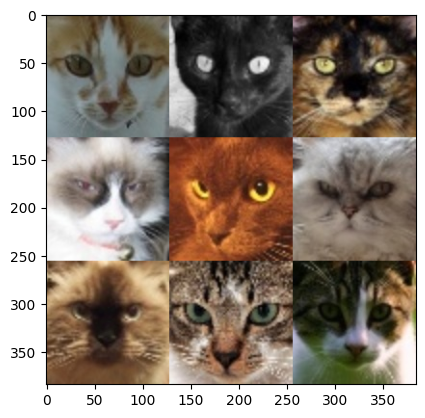

In [18]:
# Create a list of the files in our resized images folder
resized_data_filenames = [
    data_resized_dir + "/" + i for i in os.listdir(data_resized_dir)
]
show_n_images = 9
# Get a batch of 9 of the resized images
train_images = get_batch(resized_data_filenames[:show_n_images], "RGB")
# Create a grid from the resized images and then plot them
plt.imshow(images_square_grid(train_images, "RGB"))

## DCGAN

### Input

Create `placeholder`s with Tensorflow. We need to make special floats used by Tensorflow that will control the behaviour of our models. But because those values haven't been defined yet, the `placeholder`s will act as empty values.

In [19]:
def model_inputs(real_dim: int, z_dim: int):
    """Creates a set of model inputs.

    Args:
        real_dim (int): _description_
        z_dim (int): _description_

    Returns:
        _type_: _description_
    """
    inputs_real = tf.compat.v1.placeholder(
        tf.float32, (None, *real_dim), name="inputs_real"
    )
    inputs_z = tf.compat.v1.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.compat.v1.placeholder(tf.float32, name="learning_rate_G")
    learning_rate_D = tf.compat.v1.placeholder(tf.float32, name="learning_rate_D")

    return inputs_real, inputs_z, learning_rate_G, learning_rate_D

## Creating a Generator

Tensowflow allows us to group variables together in a `variable_scope`. This means that the variables belonging to the generator will all have `generator` in the name, and likewise, the variables belonging to the discriminator will have `discriminator` in the name.

This approach also means that the netowrks can be reused with different inputs.
- Generator: The generator will be trained, but we're also going to be sampling from it (retrieving our fake data) during the training.
- Discriminator: The discriminator will need to share images between the fake and real input images.

In [20]:
def generator(z, output_channel_dim, is_train=True):
    """Builds the generator network.

    Args:
        z (_type_): Input tensor for the generator.
        output_channel_dim (_type_): Shape of the generator output.
        is_train (bool, optional): True if the generator should train, and False to simply sample it.

    Returns:
        _type_: _description_
    """
    with tf.compat.v1.variable_scope("generator", reuse=not is_train):
        # First FC layer --> 8x8x1024
        fc1 = tf.compat.v1.layers.dense(z, 8 * 8 * 1024)

        # Reshape it
        fc1 = tf.reshape(fc1, (-1, 8, 8, 1024))

        # Leaky ReLU
        fc1 = tf.nn.leaky_relu(fc1, alpha=alpha)

        # Transposed conv 1 --> BatchNorm --> LeakyReLU
        # 8x8x1024 --> 16x16x512
        trans_conv1 = tf.compat.v1.layers.conv2d_transpose(
            inputs=fc1,
            filters=512,
            kernel_size=[5, 5],
            strides=[2, 2],
            padding="SAME",
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            name="trans_conv1",
        )

        batch_trans_conv1 = tf.compat.v1.layers.batch_normalization(
            inputs=trans_conv1,
            training=is_train,
            epsilon=1e-5,
            name="batch_trans_conv1",
        )

        trans_conv1_out = tf.nn.leaky_relu(
            batch_trans_conv1, alpha=alpha, name="trans_conv1_out"
        )

        # Transposed conv 2 --> BatchNorm --> LeakyReLU
        # 16x16x512 --> 32x32x256
        trans_conv2 = tf.compat.v1.layers.conv2d_transpose(
            inputs=trans_conv1_out,
            filters=256,
            kernel_size=[5, 5],
            strides=[2, 2],
            padding="SAME",
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            name="trans_conv2",
        )

        batch_trans_conv2 = tf.compat.v1.layers.batch_normalization(
            inputs=trans_conv2,
            training=is_train,
            epsilon=1e-5,
            name="batch_trans_conv2",
        )

        trans_conv2_out = tf.nn.leaky_relu(
            batch_trans_conv2, alpha=alpha, name="trans_conv2_out"
        )

        # Transposed conv 3 --> BatchNorm --> LeakyReLU
        # 32x32x256 --> 64x64x128
        trans_conv3 = tf.compat.v1.layers.conv2d_transpose(
            inputs=trans_conv2_out,
            filters=128,
            kernel_size=[5, 5],
            strides=[2, 2],
            padding="SAME",
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            name="trans_conv3",
        )

        batch_trans_conv3 = tf.compat.v1.layers.batch_normalization(
            inputs=trans_conv3,
            training=is_train,
            epsilon=1e-5,
            name="batch_trans_conv3",
        )

        trans_conv3_out = tf.nn.leaky_relu(
            batch_trans_conv3, alpha=alpha, name="trans_conv3_out"
        )

        # Transposed conv 4 --> BatchNorm --> LeakyReLU
        # 64x64x128 --> 128x128x64
        trans_conv4 = tf.compat.v1.layers.conv2d_transpose(
            inputs=trans_conv3_out,
            filters=64,
            kernel_size=[5, 5],
            strides=[2, 2],
            padding="SAME",
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            name="trans_conv4",
        )

        batch_trans_conv4 = tf.compat.v1.layers.batch_normalization(
            inputs=trans_conv4,
            training=is_train,
            epsilon=1e-5,
            name="batch_trans_conv4",
        )

        trans_conv4_out = tf.nn.leaky_relu(
            batch_trans_conv4, alpha=alpha, name="trans_conv4_out"
        )

        # Transposed conv 5 --> tanh
        # 128x128x64 --> 128x128x3
        logits = tf.compat.v1.layers.conv2d_transpose(
            inputs=trans_conv4_out,
            filters=3,
            kernel_size=[5, 5],
            strides=[1, 1],
            padding="SAME",
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            name="logits",
        )

        out = tf.tanh(logits, name="out")

        return out

## Creating a Discriminator

In [21]:
def discriminator(x, is_reuse=False, alpha=0.2):
    """Build the discriminator network.

    Arguments
    ---------
    x : Input tensor for the discriminator
    n_units: Number of units in hidden layer
    reuse : Reuse the variables with tf.variable_scope
    alpha : leak parameter for leaky ReLU

    Returns
    -------
    out, logits:
    """
    with tf.compat.v1.variable_scope("discriminator", reuse=is_reuse):
        # Input layer 128*128*3 --> 64x64x64
        # Conv --> BatchNorm --> LeakyReLU
        conv1 = tf.compat.v1.layers.conv2d(
            inputs=x,
            filters=64,
            kernel_size=[5, 5],
            strides=[2, 2],
            padding="SAME",
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            name="conv1",
        )

        batch_norm1 = tf.compat.v1.layers.batch_normalization(
            conv1, training=True, epsilon=1e-5, name="batch_norm1"
        )

        conv1_out = tf.nn.leaky_relu(batch_norm1, alpha=alpha, name="conv1_out")

        # 64x64x64--> 32x32x128
        # Conv --> BatchNorm --> LeakyReLU
        conv2 = tf.compat.v1.layers.conv2d(
            inputs=conv1_out,
            filters=128,
            kernel_size=[5, 5],
            strides=[2, 2],
            padding="SAME",
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            name="conv2",
        )

        batch_norm2 = tf.compat.v1.layers.batch_normalization(
            conv2, training=True, epsilon=1e-5, name="batch_norm2"
        )

        conv2_out = tf.nn.leaky_relu(batch_norm2, alpha=alpha, name="conv2_out")

        # 32x32x128 --> 16x16x256
        # Conv --> BatchNorm --> LeakyReLU
        conv3 = tf.compat.v1.layers.conv2d(
            inputs=conv2_out,
            filters=256,
            kernel_size=[5, 5],
            strides=[2, 2],
            padding="SAME",
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            name="conv3",
        )

        batch_norm3 = tf.compat.v1.layers.batch_normalization(
            conv3, training=True, epsilon=1e-5, name="batch_norm3"
        )

        conv3_out = tf.nn.leaky_relu(batch_norm3, alpha=alpha, name="conv3_out")

        # 16x16x256 --> 16x16x512
        # Conv --> BatchNorm --> LeakyReLU
        conv4 = tf.compat.v1.layers.conv2d(
            inputs=conv3_out,
            filters=512,
            kernel_size=[5, 5],
            strides=[1, 1],
            padding="SAME",
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            name="conv4",
        )

        batch_norm4 = tf.compat.v1.layers.batch_normalization(
            conv4, training=True, epsilon=1e-5, name="batch_norm4"
        )

        conv4_out = tf.nn.leaky_relu(batch_norm4, alpha=alpha, name="conv4_out")

        # 16x16x512 --> 8x8x1024
        # Conv --> BatchNorm --> LeakyReLU
        conv5 = tf.compat.v1.layers.conv2d(
            inputs=conv4_out,
            filters=1024,
            kernel_size=[5, 5],
            strides=[2, 2],
            padding="SAME",
            kernel_initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02),
            name="conv5",
        )

        batch_norm5 = tf.compat.v1.layers.batch_normalization(
            conv5, training=True, epsilon=1e-5, name="batch_norm5"
        )

        conv5_out = tf.nn.leaky_relu(batch_norm5, alpha=alpha, name="conv5_out")

        # Flatten it
        flatten = tf.reshape(conv5_out, (-1, 8 * 8 * 1024))

        # Logits
        logits = tf.compat.v1.layers.dense(inputs=flatten, units=1, activation=None)

        out = tf.sigmoid(logits)

        return out, logits

## Compute the Loss

The loss tells us how well the GAN is doing.

In [22]:
def model_loss(input_real, input_z, output_channel_dim, alpha):
    """Find the loss for the generator and the discriminator.

    Args:
        input_real (np.ndarray): Images from the real dataset.
        input_z (_type_): Z input.
        output_channel_dim (int): The number of channels in the output image.
        alpha (float): _description_

    Returns:
        tuple: The discriminator loss and generator loss.
    """
    # Generator network here
    g_model = generator(input_z, output_channel_dim)
    # g_model is the generator output

    # Discriminator network here
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, is_reuse=True, alpha=alpha)

    # Calculate losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )

    return d_loss, g_loss

In [23]:
def model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.compat.v1.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

    update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)

    # Generator update
    gen_updates = [op for op in update_ops if op.name.startswith("generator")]

    # Optimizers
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.compat.v1.train.AdamOptimizer(
            learning_rate=lr_D, beta1=beta1
        ).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.compat.v1.train.AdamOptimizer(
            learning_rate=lr_G, beta1=beta1
        ).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

This will show an image of our fake data while the GAN is running.

In [24]:
def show_generator_output(
    sess, n_images, input_z, out_channel_dim, image_mode, image_path, save, show
):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    :param image_path: Path to save the image
    """
    cmap = None if image_mode == "RGB" else "gray"
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False), feed_dict={input_z: example_z}
    )

    images_grid = images_square_grid(samples, image_mode)

    if save:
        # Save image
        images_grid.save(image_path, "JPEG")

    if show:
        display.clear_output(wait=True)
        plt.imshow(images_grid, cmap=cmap)
        display.display(plt.gcf())

In [25]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

## Define the Training Function

In [26]:
def train(
    epoch_count,
    batch_size,
    z_dim,
    learning_rate_D,
    learning_rate_G,
    beta1,
    get_batches,
    data_shape,
    data_image_mode,
    alpha,
):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Create our input placeholders
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], z_dim)

    # Losses
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3], alpha)

    # Optimizers
    d_opt, g_opt = model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1)

    g_losses = []
    d_losses = []

    with tf.compat.v1.Session(config=config) as sess:
        sess.run(tf.compat.v1.global_variables_initializer())

        # Saver
        saver = tf.compat.v1.train.Saver()

        num_epoch = 0

        if not os.path.isdir(image_folder):
            os.mkdir(image_folder)

        if not os.path.isdir(models_folder):
            os.mkdir(models_folder)
        model_save_path = os.path.join(models_folder, "model.cpkt")

        if from_checkpoint:
            saver.restore(sess, model_save_path)
            image_path = "new_train/new_gen_image.jpg"
            show_generator_output(
                sess,
                1,
                input_z,
                data_shape[3],
                data_image_mode,
                image_path,
                False,
                True,
            )

        for epoch_i in range(epoch_count):
            num_epoch += 1
            if num_epoch % 5 == 0:
                saver.save(sess, model_save_path)
                print("Model saved")

            # saves model every 50 epochs
            if epoch_i > 50 and epoch_i % 50 == 0:
                saver.save(
                    sess, model_save_path, global_step=epoch_i, write_meta_graph=False
                )
            for batch_images in get_batches(batch_size):
                # Random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(
                    d_opt,
                    feed_dict={
                        input_images: batch_images,
                        input_z: batch_z,
                        lr_D: learning_rate_D,
                    },
                )
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        input_images: batch_images,
                        input_z: batch_z,
                        lr_G: learning_rate_G,
                    },
                )

            # will calculate losses and generate an image for each epoch

            train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z})
            g_losses.append(train_loss_g)
            d_losses.append(train_loss_d)
            # Save it
            image_name = str(epoch_i) + ".jpg"
            image_path = os.path.join(image_folder, image_name)

            plt.title(f"Epoch {epoch_i + 1}")
            show_generator_output(
                sess, 9, input_z, data_shape[3], data_image_mode, image_path, True, True
            )
            print(
                "Epoch {}/{} |".format(epoch_i + 1, epoch_count),
                "Discriminator Loss: {:.4f} |".format(train_loss_d),
                "Generator Loss: {:.4f}".format(train_loss_g),
            )

    return d_losses, g_losses

## Set the Parameters

In [27]:
# Size input image for discriminator
real_size = (128, 128, 3)

# Size of latent vector to generator
z_dim = 100
learning_rate_D = 0.000005  # Thanks to Alexia Jolicoeur Martineau https://ajolicoeur.wordpress.com/cats/
learning_rate_G = 0.00002  # Thanks to Alexia Jolicoeur Martineau https://ajolicoeur.wordpress.com/cats/
batch_size = 32
epochs = 100
alpha = 0.2
beta1 = 0.5

In [28]:
# Load the data and train the network here
dataset = Dataset(resized_data_filenames)

In [29]:
dataset.shape

(500, 128, 128, 3)

## Train the Model

In [ ]:
with tf.Graph().as_default():
    d_losses, g_losses = train(
        epochs,
        batch_size,
        z_dim,
        learning_rate_D,
        learning_rate_G,
        beta1,
        dataset.get_batches,
        dataset.shape,
        dataset.image_mode,
        alpha,
    )

<ipython-input-20-ef43ee6068fb>:14: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  fc1 = tf.compat.v1.layers.dense(z, 8 * 8 * 1024)
<ipython-input-20-ef43ee6068fb>:24: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  trans_conv1 = tf.compat.v1.layers.conv2d_transpose(
<ipython-input-20-ef43ee6068fb>:34: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  batch_trans_conv1 = tf.compat.v1.layers.batch_normalization(
Instructions for updating:
Colocations handled automatically by placer.
<ipython-input-20-ef43ee6068fb>:47: UserWarning: `tf.layers.con

In [ ]:
fig, ax = plt.subplots()
d_losses = np.array(d_losses)
g_losses = np.array(g_losses)
plt.plot(d_losses, label="Discriminator", alpha=0.5)
plt.plot(g_losses, label="Generator", alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Improving the Generated Images

- Give it a larger dataset (>10K images)
- Run for a larger number of epochs

## Learning More About GANs

- Google GANs Course: https://developers.google.com/machine-learning/gan
- Neural Networks video series: https://youtu.be/aircAruvnKk?si=TA18yaGIBzyd9cdO

## Interesting ML / GANs Tools

- [Machine Learning for Art](https://ml4a.net/)
- [Text to Image](https://colab.research.google.com/drive/1L14q4To5rMK8q2E6whOibQBnPnVbRJ_7?usp=sharing) Notebook. Also a [blog post](https://amyelizabethsmith01.medium.com/gans-sanrio-ganrio-21e263666929) about the notebook.
- Awesome Applications of GANs: https://github.com/nashory/gans-awesome-applications

## Feedback

Please fill in the feedback form: https://moodle.arts.ac.uk/mod/feedback/view.php?id=1365755

## Attendance

Please give me your names so I can keep track of attendance!
